## Importing required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.cluster import AgglomerativeClustering

## Reading input files

In [2]:
train = pd.read_csv("train.csv", keep_default_na=False)

In [3]:
test = pd.read_csv("test.csv", keep_default_na=False)

In [4]:
submission = pd.read_csv("submission.csv", keep_default_na=False)

## Analysis of test, train and submission data

In [5]:
print(
    train.shape, test.shape, submission.shape
)

((20580, 6), (12642, 4), (12642, 3))


In [6]:
print(train.dtypes)
print(test.dtypes)
print(submission.dtypes)

Id                  int64
Province_State     object
Country_Region     object
Date               object
ConfirmedCases    float64
Fatalities        float64
dtype: object
ForecastId         int64
Province_State    object
Country_Region    object
Date              object
dtype: object
ForecastId        int64
ConfirmedCases    int64
Fatalities        int64
dtype: object


In [7]:
train.head(5)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,,Afghanistan,2020-01-22,0.0,0.0
1,2,,Afghanistan,2020-01-23,0.0,0.0
2,3,,Afghanistan,2020-01-24,0.0,0.0
3,4,,Afghanistan,2020-01-25,0.0,0.0
4,5,,Afghanistan,2020-01-26,0.0,0.0


In [8]:
test.head(5)

,ForecastId,Province_State,Country_Region,Date
0,1,,Afghanistan,2020-03-19
1,2,,Afghanistan,2020-03-20
2,3,,Afghanistan,2020-03-21
3,4,,Afghanistan,2020-03-22
4,5,,Afghanistan,2020-03-23


In [9]:
submission.head(5)

,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


## Analysis for each attribute of train data

In [10]:
# test the missing type data
def mis_test(attr):
    return  len(attr.unique()), [x for x in attr.unique() if x == float("NaN") or x == ""]

In [11]:
train.shape

(20580, 6)

In [12]:
mis_test(train.Id)

(20580, [])

In [13]:
mis_test(train.Province_State)

(126, [''])

In [14]:
mis_test(train.Country_Region)

(173, [])

In [15]:
mis_test(train.Date)

(70, [])

In [16]:
mis_test(train.ConfirmedCases)

(1536, [])

In [17]:
mis_test(train.Fatalities)

(328, [])

In [18]:
train.describe()

,Id,ConfirmedCases,Fatalities
count,20580.000000,20580.000000,20580.000000
mean,14685.500000,514.939116,21.080952
std,8487.230117,4541.261768,287.758197
min,1.000000,0.000000,0.000000
25%,7335.750000,0.000000,0.000000
50%,14685.500000,0.000000,0.000000
75%,22035.250000,35.000000,0.000000
max,29370.000000,105792.000000,12428.000000


## Test for Province_State vs Country_Region

In [19]:
# check for Country_Region having more than one Province_State have any missing entry or not
country_list = []
df = train.groupby(train.Country_Region).nunique()
for i in df[df.Province_State > 1].index:
    z = [x for x in train[train.Country_Region == i].Province_State.unique() if x == ""]
    k = []
    if z:
        k = train[train.Country_Region == i].Province_State.unique()
        country_list.append(i)
    print(i, z, k)
print(country_list)

('Australia', [], [])
('Canada', [], [])
('China', [], [])
('Denmark', [''], array(['Faroe Islands', 'Greenland', ''], dtype=object))
('France', [''], array(['French Guiana', 'French Polynesia', 'Guadeloupe', 'Martinique',
       'Mayotte', 'New Caledonia', 'Reunion', 'Saint Barthelemy',
       'St Martin', ''], dtype=object))
('Netherlands', [''], array(['Aruba', 'Curacao', 'Sint Maarten', ''], dtype=object))
('US', [], [])
('United Kingdom', [''], array(['Bermuda', 'Cayman Islands', 'Channel Islands', 'Gibraltar',
       'Isle of Man', 'Montserrat', ''], dtype=object))
['Denmark', 'France', 'Netherlands', 'United Kingdom']


In [20]:
train[train.Country_Region.isin(country_list)].groupby(
    ["Country_Region", "Province_State"]
).count()

Id  Date  ConfirmedCases  Fatalities
Country_Region Province_State                                        
Denmark                          70    70              70          70
               Faroe Islands     70    70              70          70
               Greenland         70    70              70          70
France                           70    70              70          70
               French Guiana     70    70              70          70
               French Polynesia  70    70              70          70
               Guadeloupe        70    70              70          70
               Martinique        70    70              70          70
               Mayotte           70    70              70          70
               New Caledonia     70    70              70          70
               Reunion           70    70              70          70
               Saint Barthelemy  70    70              70          70
               St Martin         70    70              70          70
Netherlands                      70    70              70          70
               Aruba             70    70              70          70
               Curacao           70    70              70          70
               Sint Maarten      70    70              70          70
United Kingdom                   70    70              70          70
               Bermuda           70    70              70          70
               Cayman Islands    70    70              70          70
               Channel Islands   70    70              70          70
               Gibraltar         70    70              70          70
               Isle of Man       70    70              70          70
               Montserrat        70    70              70          70

## Impute missing value of Province_State with Country_Region as missing value represents rest or whole of the Country_Region

In [21]:
train['Province_State'] = train.apply(
    lambda row: row['Country_Region'] if row['Province_State'] == "" else row['Province_State'],
    axis=1
)

## Check whether ConfirmedCases and Fatalities are cumulative or not
- verify result with https://www.worldometers.info/coronavirus/country/india/

In [22]:
train[train.Country_Region == "India"].tail(10)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
9440,13461,India,India,2020-03-22,396.0,7.0
9441,13462,India,India,2020-03-23,499.0,10.0
9442,13463,India,India,2020-03-24,536.0,10.0
9443,13464,India,India,2020-03-25,657.0,12.0
9444,13465,India,India,2020-03-26,727.0,20.0
9445,13466,India,India,2020-03-27,887.0,20.0
9446,13467,India,India,2020-03-28,987.0,24.0
9447,13468,India,India,2020-03-29,1024.0,27.0
9448,13469,India,India,2020-03-30,1251.0,32.0
9449,13470,India,India,2020-03-31,1397.0,35.0


---

# Task 1: Clustering of data

## Analysis of daywise change in ConfirmedCases and Fatalities
- To analyse the growth rate and death rate

In [23]:
train_new = train[["Province_State", "Date", "ConfirmedCases", "Fatalities"]].sort_values(
    by=["Province_State", "Date"]
)
train_new["growth_rate"] = train_new.ConfirmedCases.diff(periods=1)
train_new["death_rate"] = train_new.Fatalities.diff(periods=1)

train_new['growth_rate'] = train_new.apply(
    lambda row: row['ConfirmedCases'] if row['growth_rate'] < 0 else row['growth_rate'],
    axis=1
)
train_new['death_rate'] = train_new.apply(
    lambda row: row['Fatalities'] if row['death_rate'] < 0 else row['death_rate'],
    axis=1
)
train_new = train_new[train_new.ConfirmedCases > 0]

## Analysis for top 10 Province_State
- To identify the growth and death rate
- Calculate top 10 contryies having higher cases and deaths
- check mean and median per Province_State for top 10 countries from new cases and deaths

In [24]:
df2 = train.groupby(train.Province_State).max()[["ConfirmedCases", "Fatalities"]]
df2["case_rank"] = df2["ConfirmedCases"].rank(method="dense", ascending=False)
df2["fat_rank"] = df2["Fatalities"].rank(method="dense", ascending=False)

In [25]:
df2.sort_values(by=["case_rank", "fat_rank"]).head(10)

,ConfirmedCases,Fatalities,case_rank,fat_rank
Province_State,,,,
Italy,105792.0,12428.0,1.0,1.0
Spain,95923.0,8464.0,2.0,2.0
New York,75833.0,1550.0,3.0,7.0
Germany,71808.0,775.0,4.0,9.0
Hubei,67801.0,3187.0,5.0,4.0
France,52128.0,3523.0,6.0,3.0
Iran,44605.0,2898.0,7.0,5.0
United Kingdom,25150.0,1789.0,8.0,6.0
New Jersey,18696.0,267.0,9.0,12.0


In [26]:
df2.sort_values(by=["fat_rank", "case_rank"]).head(10)

,ConfirmedCases,Fatalities,case_rank,fat_rank
Province_State,,,,
Italy,105792.0,12428.0,1.0,1.0
Spain,95923.0,8464.0,2.0,2.0
France,52128.0,3523.0,6.0,3.0
Hubei,67801.0,3187.0,5.0,4.0
Iran,44605.0,2898.0,7.0,5.0
United Kingdom,25150.0,1789.0,8.0,6.0
New York,75833.0,1550.0,3.0,7.0
Netherlands,12595.0,1039.0,13.0,8.0
Germany,71808.0,775.0,4.0,9.0


In [27]:
df3 = train_new.set_index("Province_State")[["Date", "growth_rate", "death_rate"]].join(
    df2[df2.case_rank <= 10],
    on="Province_State",
    how="inner"
)

In [28]:
df3[["growth_rate", "death_rate"]].groupby("Province_State").agg(
    ["mean", "median"]
).describe()

growth_rate               death_rate           
              mean       median        mean     median
count    10.000000    10.000000   10.000000  10.000000
mean   1240.526578   530.950000   64.695426  11.450000
std     884.131422   976.525145   62.649613  18.967004
min     412.295082     4.000000   11.923077   0.000000
25%     787.395722    20.875000   16.434240   0.000000
50%    1015.304762   195.000000   48.640126   2.750000
75%    1475.222115   402.000000   70.090909  14.750000
max    3446.954545  3172.500000  203.737705  58.500000

# Use Mean as growth and death rate from the above observation
- Mean is more close to centre of min and max values as compared to median

In [29]:
df4 = train_new.groupby(
    ["Province_State"]).agg(
    {
        "growth_rate": "mean",
        "ConfirmedCases": "max"
    }
)
df5 = train_new[train_new.Fatalities > 0].groupby(
    ["Province_State"]).agg(
    {
        "death_rate": "mean",
        "Fatalities": "max"
    }
)
data = df4.join(
    df5, "Province_State"
).fillna(0)

In [30]:
data.head(10)

,ConfirmedCases,growth_rate,Fatalities,death_rate
Province_State,,,,
Afghanistan,174.0,4.702703,4.0,0.400000
Alabama,987.0,51.947368,23.0,3.285714
Alaska,119.0,6.666667,3.0,0.428571
Albania,243.0,10.565217,15.0,0.714286
Alberta,690.0,40.346154,8.0,0.666667
Algeria,716.0,19.888889,44.0,2.200000
Andorra,376.0,12.533333,12.0,1.200000
Angola,7.0,0.583333,2.0,0.666667
Anhui,990.0,14.142857,6.0,0.115385


## Standarization of data and identification of number of clusters
- elbow method
- dendograms

In [31]:
# Standarized all the four feature variables
mms = StandardScaler()
mms.fit(data)
data_transformed = mms.transform(data)

In [32]:
# Elbow method
Sum_of_squared_distances = []
K = range(1,15, 1)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

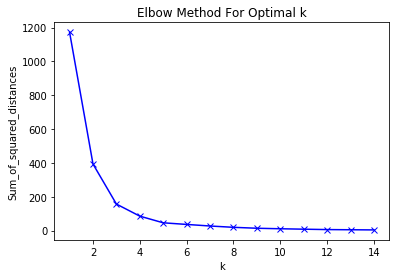

In [33]:
# plot of elbow method
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

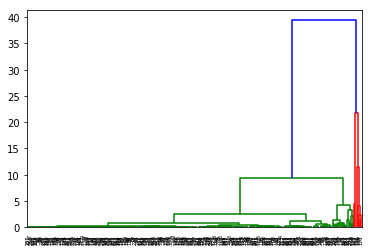

In [34]:
dendrogram = sch.dendrogram(sch.linkage(data_transformed, method='ward'))

## Apply K-means with 4 clusters as confirmed by both elbow method and dendograms

In [35]:
kmeans = KMeans(n_clusters=4).fit(data_transformed)
centroids = kmeans.cluster_centers_
print(centroids)
# print(kmeans.labels_)
data["clusters"] = kmeans.labels_

[[-0.15333655 -0.13220555 -0.12474492 -0.12433137]
 [ 4.18444169  2.82770567  2.43361935  2.00809458]
 [ 8.2998488   5.7147056  10.94508351 11.16714924]
 [ 6.17901037 12.11064128  1.49403938  3.05966914]]


In [36]:
df6 = data.reset_index()[["Province_State", "clusters"]]
df6.sort_values(by="clusters", ascending=False).head(10)

,Province_State,clusters
187,New York,3
125,Italy,2
249,Spain,2
77,France,1
85,Germany,1
273,United Kingdom,1
120,Iran,1
109,Hubei,1
190,Nicaragua,0
191,Niger,0


## reduce features to plot in 2-D using PCA

In [37]:
reduced_data = PCA(n_components=2).fit_transform(data)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
# results

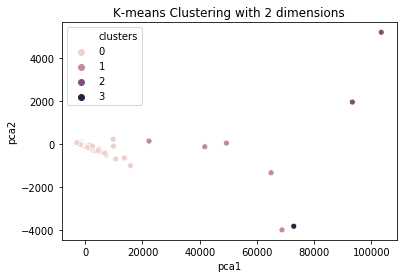

In [38]:
sns.scatterplot(x="pca1", y="pca2", hue=df6['clusters'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

## Save cluster result to csv file

In [39]:
df6.to_csv("country_clusters.csv", index=False)

___

# Task 2: Forcast future data

In [40]:
# model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
# model.fit(data_transformed)
# labels = model.labels_

# plt.scatter(data_transformed[labels==0, 0], data_transformed[labels==0, 1], s=50, marker='o', color='red')
# plt.scatter(data_transformed[labels==1, 0], data_transformed[labels==1, 1], s=50, marker='o', color='blue')
# plt.scatter(data_transformed[labels==2, 0], data_transformed[labels==2, 1], s=50, marker='o', color='green')
# plt.scatter(data_transformed[labels==3, 0], data_transformed[labels==3, 1], s=50, marker='o', color='purple')
# plt.show()

# plt.scatter(df6.Province_State,df6['clusters'], c='rainbow')
# # plt.plot(data[["ConfirmedCases", "growth_rate", "Fatalities","death_rate"]])
# plt.show()